In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")


# Load Online Retail II dataset
df = pd.read_csv(
    "/content/online_retail_II.csv"
)

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [6]:
#DATA CLEANING

# Remove cancelled orders
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Drop rows with missing customer IDs
df = df.dropna(subset=['Customer ID'])

# Remove invalid quantities and prices
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# Convert data types
df['Customer ID'] = df['Customer ID'].astype(int)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create transaction value
df['TotalValue'] = df['Quantity'] * df['Price']

df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalValue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


In [8]:
customer_df = df.groupby('Customer ID').agg(
    total_revenue=('TotalValue', 'sum'),
    total_orders=('Invoice', 'nunique'),
    total_quantity=('Quantity', 'sum'),
    avg_order_value=('TotalValue', 'mean'),
    purchase_std=('TotalValue', 'std')
).reset_index()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalValue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


In [9]:
# Customers with only one purchase have NaN std
customer_df['purchase_std'] = customer_df['purchase_std'].fillna(0)

# Normalize volatility by spending level
customer_df['volatility_ratio'] = (
    customer_df['purchase_std'] / customer_df['avg_order_value']
)


In [10]:
#IMPLEMENTING ML MODELS
from sklearn.preprocessing import StandardScaler

features = [
    'total_revenue',
    'total_orders',
    'avg_order_value',
    'volatility_ratio'
]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_df[features])

from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=4,
    random_state=42,
    n_init=10
)

customer_df['segment'] = kmeans.fit_predict(scaled_features)

segment_profile = customer_df.groupby('segment').agg(
    customers=('Customer ID', 'count'),
    avg_revenue=('total_revenue', 'mean'),
    avg_orders=('total_orders', 'mean'),
    avg_volatility=('volatility_ratio', 'mean')
).round(2)

segment_profile


,customers,avg_revenue,avg_orders,avg_volatility
segment,,,,
0,1562,5310.27,11.37,1.33
1,4298,1381.96,3.81,0.58
2,1,168472.50,2.00,1.73
3,17,196509.10,165.65,1.49


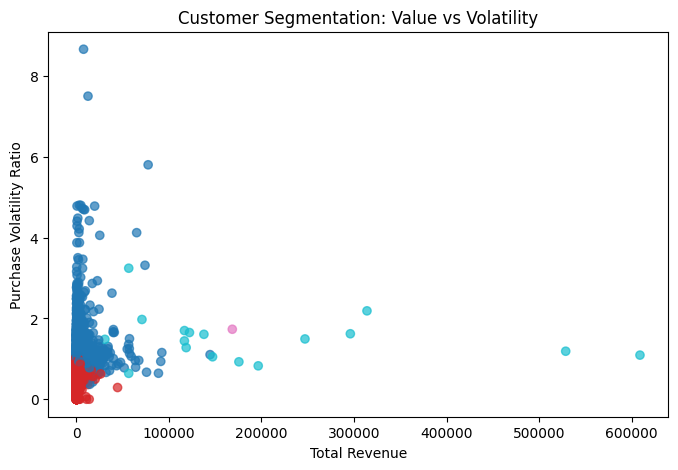

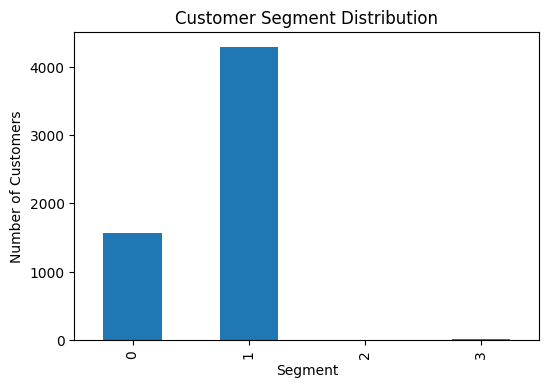

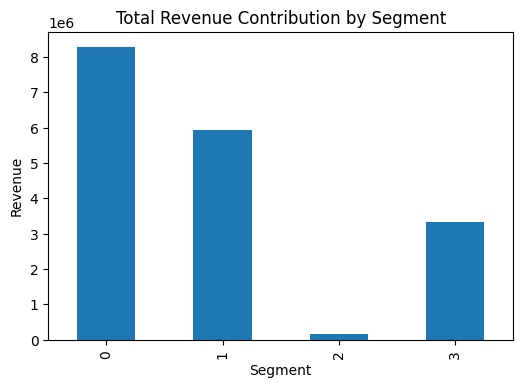

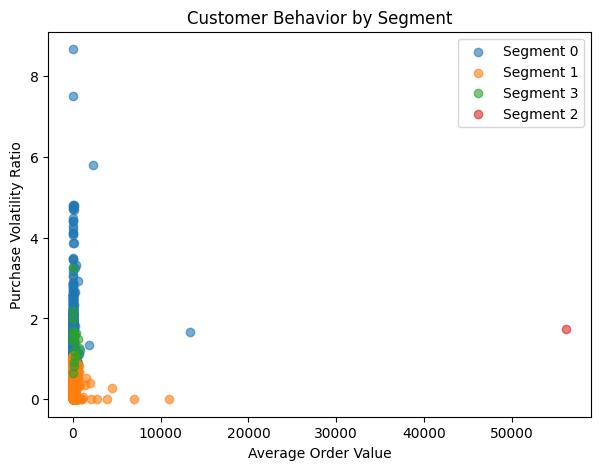

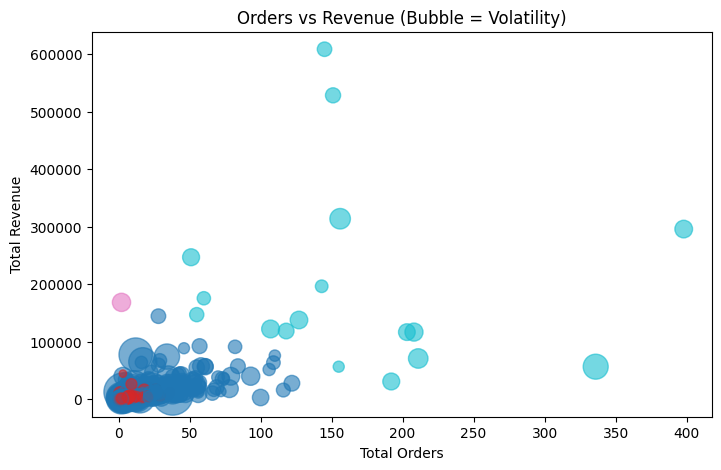

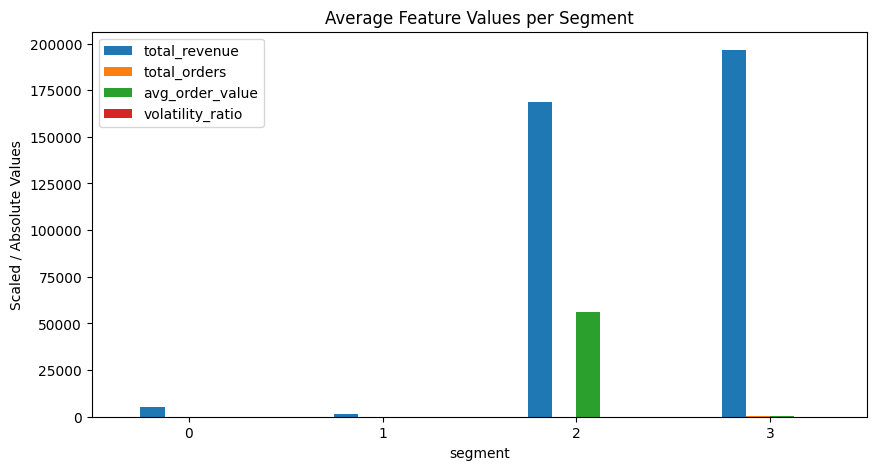

np.float64(0.4728382852154894)

In [13]:
#VISUALIZATIONS

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.scatter(
    customer_df['total_revenue'],
    customer_df['volatility_ratio'],
    c=customer_df['segment'],
    cmap='tab10',
    alpha=0.7
)

plt.xlabel("Total Revenue")
plt.ylabel("Purchase Volatility Ratio")
plt.title("Customer Segmentation: Value vs Volatility")
plt.show()


#SEGMENT DISTRIBUTIONS
segment_counts = customer_df['segment'].value_counts().sort_index()

plt.figure(figsize=(6,4))
segment_counts.plot(kind='bar')
plt.title("Customer Segment Distribution")
plt.xlabel("Segment")
plt.ylabel("Number of Customers")
plt.show()

#Revenue Contribution by Segment
segment_revenue = customer_df.groupby('segment')['total_revenue'].sum()

plt.figure(figsize=(6,4))
segment_revenue.plot(kind='bar')
plt.title("Total Revenue Contribution by Segment")
plt.xlabel("Segment")
plt.ylabel("Revenue")
plt.show()

   #Average Order Value vs Volatility
plt.figure(figsize=(7,5))

for seg in customer_df['segment'].unique():
    subset = customer_df[customer_df['segment'] == seg]
    plt.scatter(
        subset['avg_order_value'],
        subset['volatility_ratio'],
        label=f"Segment {seg}",
        alpha=0.6
    )

plt.xlabel("Average Order Value")
plt.ylabel("Purchase Volatility Ratio")
plt.title("Customer Behavior by Segment")
plt.legend()
plt.show()


#Orders vs Revenue Bubble Chart
plt.figure(figsize=(8,5))

plt.scatter(
    customer_df['total_orders'],
    customer_df['total_revenue'],
    s=customer_df['volatility_ratio'] * 100,
    c=customer_df['segment'],
    cmap='tab10',
    alpha=0.6
)

plt.xlabel("Total Orders")
plt.ylabel("Total Revenue")
plt.title("Orders vs Revenue (Bubble = Volatility)")
plt.show()


#Segment Feature Comparison
segment_means = customer_df.groupby('segment')[features].mean()

segment_means.plot(kind='bar', figsize=(10,5))
plt.title("Average Feature Values per Segment")
plt.ylabel("Scaled / Absolute Values")
plt.xticks(rotation=0)
plt.show()

#Silhouette Score
# """ Silhouette Score measures how well customers are clustered:
#   Values close to +1 indicate well-separated, cohesive segments
#   Values near 0 suggest overlapping segments
#   Negative values indicate poor clustering
#  In this project, it validates that customer segments based on value
#  and purchase volatility are meaningfully distinct and interpretable. """

from sklearn.metrics import silhouette_score

score = silhouette_score(scaled_features, customer_df['segment'])
score
